In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import joblib    
import pickle
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=40

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Ishita\IGDTUW (CSE)\Summer Internship 2023\PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

(32, 256, 256, 3)
[0 0 2 0 1 1 1 0 1 1 1 2 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 1 0 1 0 1]


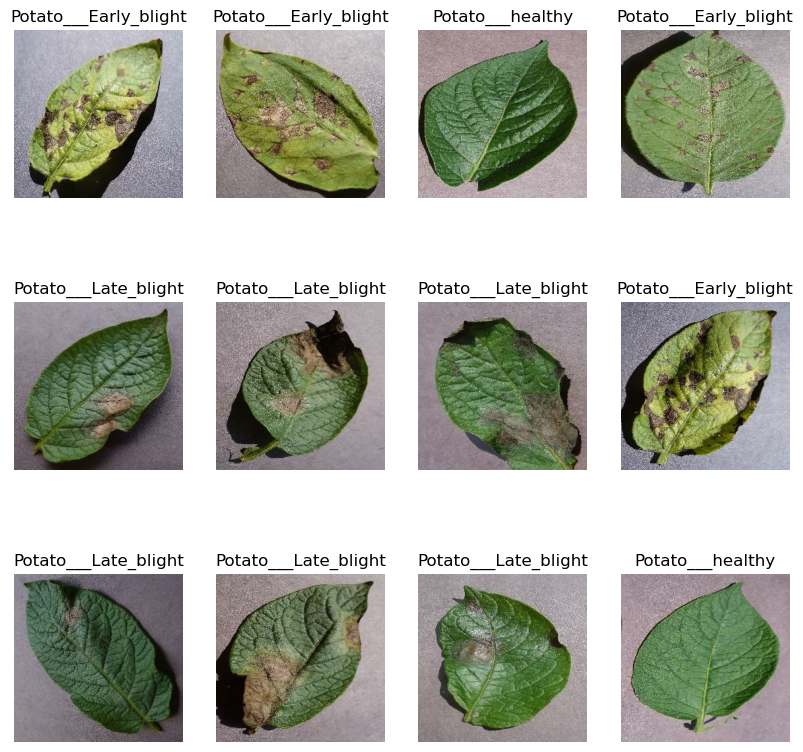

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [8]:
print(len(train_ds), len(val_ds), len(test_ds))

54 6 8


In [9]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/40
54/54 [==============================] - 72s 1s/step - loss: 0.8743 - accuracy: 0.5208 - val_loss: 0.7992 - val_accuracy: 0.6354
Epoch 2/40
54/54 [==============================] - 68s 1s/step - loss: 0.6321 - accuracy: 0.7159 - val_loss: 0.5720 - val_accuracy: 0.7552
Epoch 3/40
54/54 [==============================] - 68s 1s/step - loss: 0.4484 - accuracy: 0.8206 - val_loss: 0.3762 - val_accuracy: 0.8490
Epoch 4/40
54/54 [==============================] - 69s 1s/step - loss: 0.2442 - accuracy: 0.9028 - val_loss: 0.7472 - val_accuracy: 0.6771
Epoch 5/40
54/54 [==============================] - 69s 1s/step - loss: 0.2423 - accuracy: 0.9115 - val_loss: 0.4729 - val_accuracy: 0.7969
Epoch 6/40
54/54 [==============================] - 68s 1s/step - loss: 0.1737 - accuracy: 0.9334 - val_loss: 0.2162 - val_accuracy: 0.8958
Epoch 7/40
54/54 [==============================] - 68s 1s/step - loss: 0.1215 - accuracy: 0.9554 - val_loss: 0.2886 - val_accuracy: 0.8802
Epoch 8/40
54/54 [==

In [13]:
scores=model.evaluate(test_ds)
scores

8/8 [==============================] - 3s 239ms/step - loss: 0.0735 - accuracy: 0.9844


[0.0734885036945343, 0.984375]

In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [15]:
history.history['loss']

[0.8742867708206177,
 0.6320645809173584,
 0.44840776920318604,
 0.24419532716274261,
 0.24228857457637787,
 0.17368227243423462,
 0.12148891389369965,
 0.09789112210273743,
 0.11178147047758102,
 0.08336915820837021,
 0.1315191090106964,
 0.07403984665870667,
 0.08792910724878311,
 0.10618620365858078,
 0.07083535939455032,
 0.0733007863163948,
 0.07635752111673355,
 0.058407027274370193,
 0.11712794750928879,
 0.055385932326316833,
 0.0520532988011837,
 0.05317787826061249,
 0.047307126224040985,
 0.05333852395415306,
 0.09243904054164886,
 0.045258354395627975,
 0.0249054916203022,
 0.04268132150173187,
 0.04408106580376625,
 0.08450048416852951,
 0.05819084867835045,
 0.04046056047081947,
 0.022136185318231583,
 0.08842509984970093,
 0.08506675809621811,
 0.03369982913136482,
 0.057403530925512314,
 0.0326298251748085,
 0.04937305301427841,
 0.035951752215623856]

In [16]:
history.history['accuracy']

[0.5208333134651184,
 0.7158564925193787,
 0.8206018805503845,
 0.9027777910232544,
 0.9114583134651184,
 0.9334490895271301,
 0.9554398059844971,
 0.9623842835426331,
 0.9554398059844971,
 0.9693287014961243,
 0.9461805820465088,
 0.9722222089767456,
 0.9681712985038757,
 0.9670138955116272,
 0.9733796119689941,
 0.9733796119689941,
 0.9756944179534912,
 0.9785879850387573,
 0.9589120149612427,
 0.9791666865348816,
 0.9820601940155029,
 0.9820601940155029,
 0.9837962985038757,
 0.9780092835426331,
 0.9658564925193787,
 0.9826388955116272,
 0.9901620149612427,
 0.9803240895271301,
 0.9849537014961243,
 0.9658564925193787,
 0.9774305820465088,
 0.9820601940155029,
 0.9930555820465088,
 0.9710648059844971,
 0.9716435074806213,
 0.9878472089767456,
 0.9809027910232544,
 0.9855324029922485,
 0.9826388955116272,
 0.9878472089767456]

In [17]:
history.history['val_loss']

[0.7991696000099182,
 0.5720488429069519,
 0.3761625289916992,
 0.7472443580627441,
 0.47287654876708984,
 0.2162088006734848,
 0.2885586619377136,
 0.17849485576152802,
 0.16878323256969452,
 0.3538433015346527,
 0.15163947641849518,
 0.3160190284252167,
 0.25426390767097473,
 0.08041927963495255,
 0.4622018039226532,
 0.10459917783737183,
 0.10567124933004379,
 0.07405143976211548,
 0.1998603194952011,
 0.08313813805580139,
 0.25213944911956787,
 0.06262928247451782,
 0.06749553233385086,
 0.09290897846221924,
 0.049231767654418945,
 0.05642014369368553,
 0.03523939102888107,
 0.20479130744934082,
 0.04561619833111763,
 0.07482359558343887,
 0.1052931621670723,
 0.1686001867055893,
 0.07989881187677383,
 0.697139322757721,
 0.14079450070858002,
 0.11453038454055786,
 0.11893323808908463,
 0.13041840493679047,
 0.2394973188638687,
 0.11991455405950546]

In [18]:
history.history['val_accuracy']

[0.6354166865348816,
 0.7552083134651184,
 0.8489583134651184,
 0.6770833134651184,
 0.796875,
 0.8958333134651184,
 0.8802083134651184,
 0.90625,
 0.9270833134651184,
 0.8697916865348816,
 0.9479166865348816,
 0.859375,
 0.90625,
 0.96875,
 0.8489583134651184,
 0.9583333134651184,
 0.9583333134651184,
 0.96875,
 0.9270833134651184,
 0.9583333134651184,
 0.8958333134651184,
 0.9583333134651184,
 0.9791666865348816,
 0.9479166865348816,
 0.984375,
 0.9739583134651184,
 0.9895833134651184,
 0.9114583134651184,
 0.96875,
 0.9635416865348816,
 0.953125,
 0.9375,
 0.96875,
 0.7291666865348816,
 0.953125,
 0.9479166865348816,
 0.96875,
 0.9583333134651184,
 0.9166666865348816,
 0.953125]

In [19]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

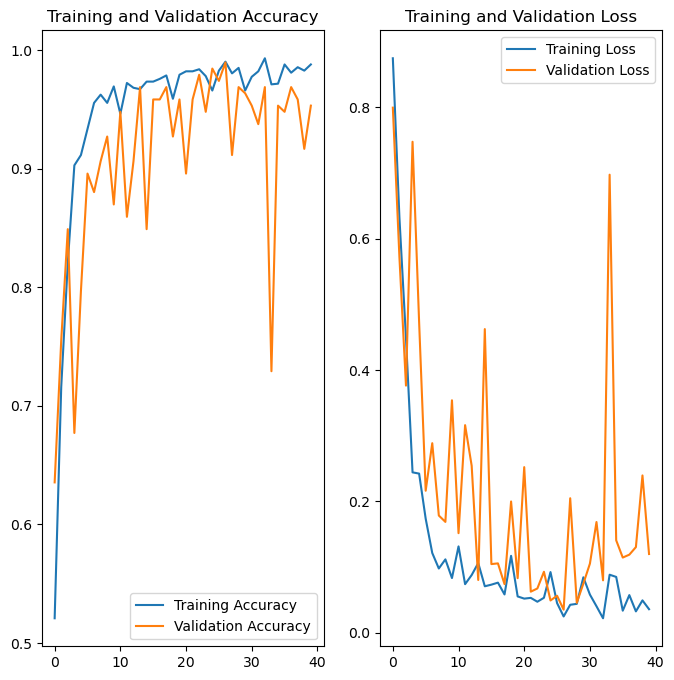

In [20]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [21]:
true_labels = []
pred_labels = []
for images_batch, labels_batch in test_ds.take(8):
    batch_prediction=model.predict(images_batch).argmax(axis=1)
    for i in labels_batch:
        true_labels.append(i)
    for i in batch_prediction:
        pred_labels.append(i)

1/1 [==============================] - 0s 429ms/step


In [22]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 64ms/step


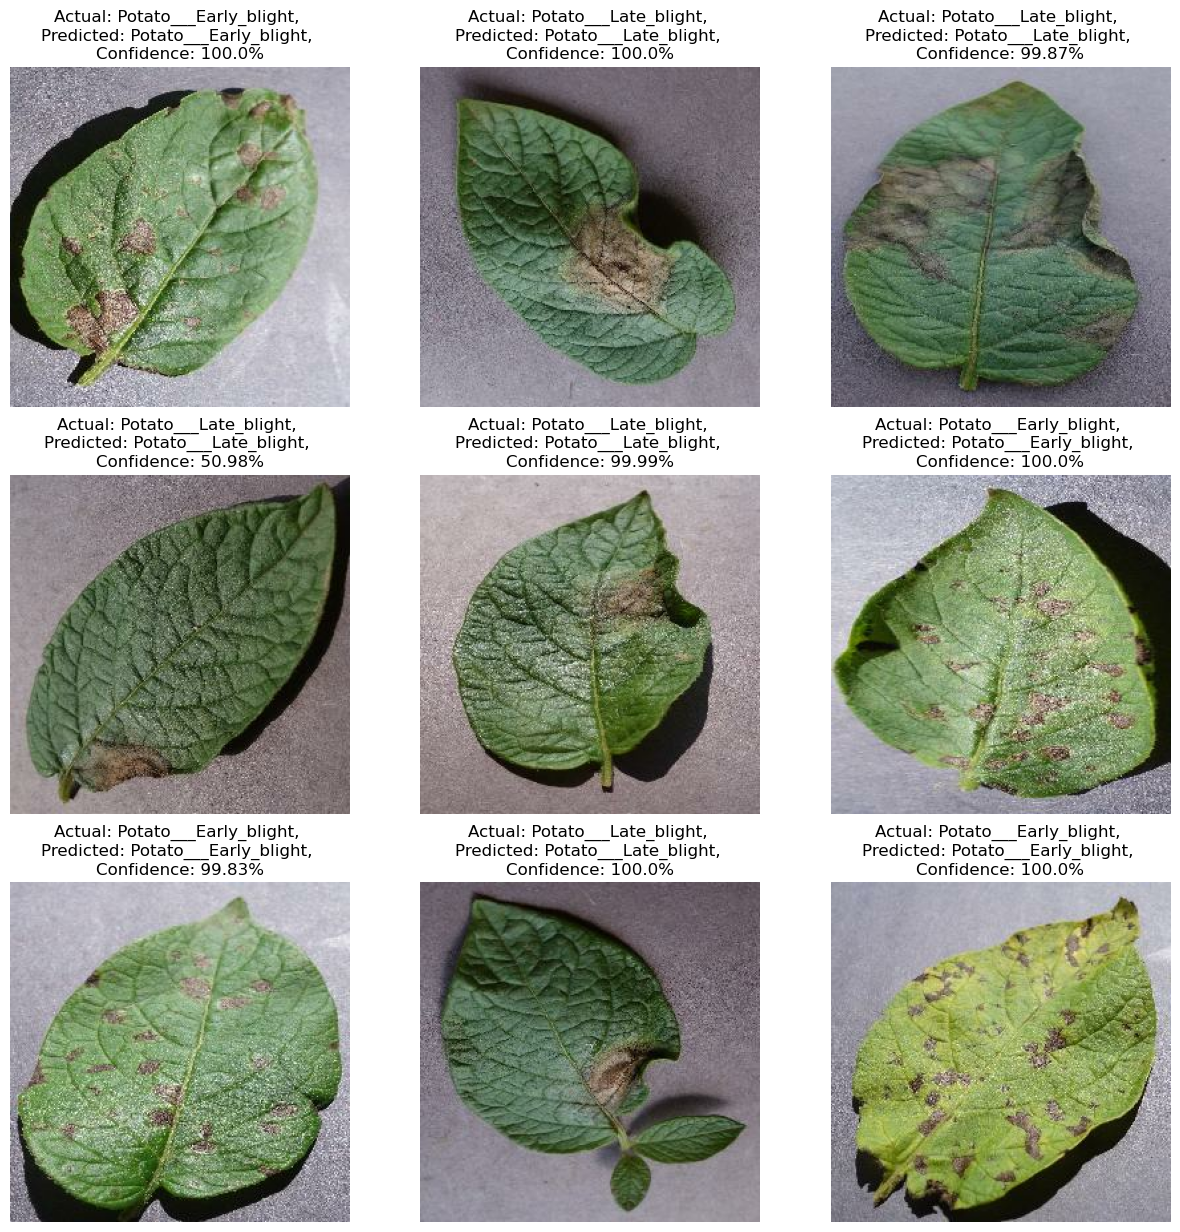

In [23]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")
        plt.axis("off")

In [24]:
print ("Classification Report: \n", classification_report(true_labels, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       133
           1       0.98      0.98      0.98       107
           2       0.93      0.88      0.90        16

    accuracy                           0.98       256
   macro avg       0.97      0.95      0.96       256
weighted avg       0.98      0.98      0.98       256



In [25]:
cm=tf.math.confusion_matrix(true_labels, pred_labels)
cm

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[133,   0,   0],
       [  1, 105,   1],
       [  0,   2,  14]])>

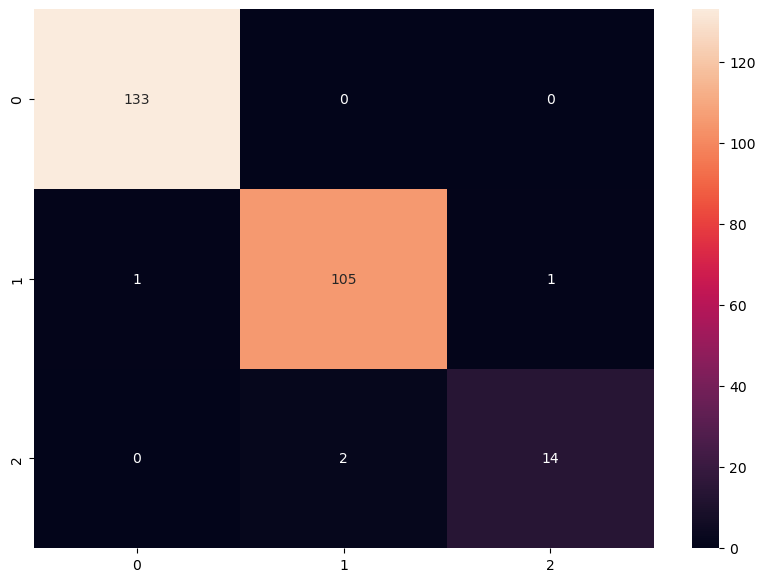

In [26]:
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel=('Predicted')
plt.ylabel=('Truth')

In [27]:
filename = "Model1-Epochs40.joblib"
joblib.dump(model, filename)

['Model1-Epochs40.joblib']